In [1]:
import gym
import MCTSnet
import copy
import torch

In [2]:
env = gym.make("SokobanEnc-v0")

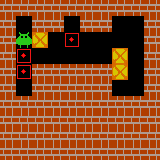

In [3]:
env.render()

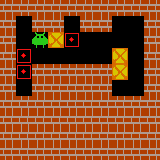

In [4]:
res = env.step(3)
env.render()

In [5]:
e = MCTSnet.models.embedding.Epsilon()

In [6]:
state = torch.Tensor(res[0])
state.reshape((-1,4,10,10)).shape

torch.Size([1, 4, 10, 10])

In [7]:
embed = e.forward(state.reshape((-1, 4, 10, 10)))

In [8]:
reward = torch.tensor([res[1]], requires_grad=True)
action = torch.tensor([3.], requires_grad=True)

In [9]:
b = MCTSnet.models.backup.BetaMLP()

In [10]:
h_s = b(embed, embed, reward.reshape((-1, 1)), action.reshape((-1, 1)))

In [11]:
r = MCTSnet.models.readout.Rho()

In [12]:
r(h_s)

tensor([[0.1336, 0.1265, 0.1206, 0.1230, 0.1243, 0.1261, 0.1145, 0.1315]],
       grad_fn=<SoftmaxBackward>)

In [13]:
pi0 = MCTSnet.models.policy.PiLogits()
pi0(h_s)

tensor([[0.0000, 0.0011, 0.0636, 0.0279, 0.0000, 0.0345, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

In [14]:
h_s

tensor([[0.0000, 0.0000, 0.1576, 0.0000, 0.0000, 0.0000, 0.0253, 0.0000, 0.1973,
         0.0000, 0.0000, 0.0083, 0.1636, 0.0000, 0.1915, 0.1127, 0.0000, 0.2099,
         0.0000, 0.0213, 0.0921, 0.0000, 0.0000, 0.0823, 0.0000, 0.0000, 0.0334,
         0.0000, 0.0000, 0.0000, 0.1694, 0.1015, 0.0000, 0.0000, 0.0714, 0.0000,
         0.0000, 0.1474, 0.0000, 0.0000, 0.0060, 0.0159, 0.0061, 0.0000, 0.0000,
         0.0338, 0.0000, 0.1511, 0.0000, 0.0000, 0.0000, 0.1026, 0.1153, 0.0845,
         0.1034, 0.0000, 0.0000, 0.0000, 0.0000, 0.1207, 0.1974, 0.1620, 0.0930,
         0.0000, 0.0372, 0.0000, 0.1996, 0.0000, 0.0000, 0.0492, 0.0000, 0.0130,
         0.1293, 0.1539, 0.0000, 0.0000, 0.0000, 0.0000, 0.0840, 0.0719, 0.0000,
         0.0114, 0.0000, 0.0000, 0.0000, 0.1169, 0.0913, 0.0000, 0.1469, 0.0897,
         0.0000, 0.0017, 0.1524, 0.1405, 0.0143, 0.2109, 0.0000, 0.0000, 0.0000,
         0.2086, 0.0000, 0.0397, 0.1631, 0.0000, 0.0726, 0.1008, 0.1391, 0.0000,
         0.0603, 0.0067, 0.0

In [15]:
pi1 = MCTSnet.models.policy.PiPriorLogits()
pi1(torch.cat((h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s), dim=0).reshape((-1, 9, 128, 1)))

tensor([[0.0000, 0.0340, 0.0403, 0.0000, 0.0174, 0.0592, 0.0236, 0.0716]],
       grad_fn=<ReluBackward0>)

In [17]:
pi = MCTSnet.models.policy.Pi()
pi(torch.cat((h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s), dim=0).reshape(-1, 9, 128))

tensor([[0.1227, 0.1248, 0.1298, 0.1227, 0.1244, 0.1252, 0.1256, 0.1249]],
       grad_fn=<SoftmaxBackward>)